In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sqlite3
from typing import Any, Optional
from pydantic import BaseModel, Extra, Field
from transformers import TrainingArguments, AutoModel, AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
import numpy as np
import json
import datasets
import wandb
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys
sys.path.append('../../')
sys.path.append('./set_transformer/')
from subset_active_learning.subset_selection import select, preprocess
from subset_active_learning.active_learning.subset_classifier import get_df_from_db

2022-10-22 23:30:34.960797: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2022-10-22 23:30:34.960840: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
save_path = 'deepset.pt'

db_path = "./temp.db"
seed = 0
wandb_project = 'sst_search_test'
wandb_entity = 'johntzwei'

embedding_type = 'both'
num_embeddings = 1000   # dataset dependent
embedding_dim = 768 + 4096
enc_dim = 2048
dec_dim = 2048

model_card = "roberta-base"
pretraining = True
max_steps = 10000
eval_steps = 1000
learning_rate = 1e-5
batch_size = 32
# adam should default to correct_bias = True
adam_epsilon = 1e-6
adam_beta1 = 0.9
adam_beta2 = 0.999
max_grad_norm = 1.0
weight_decay = 0.01

In [4]:
db_path = '../../scripts/active_learning/sst_genetic_fixed_validation.db'

In [5]:
params = select.SubsetTrainingArguments(model_card=model_card,
                                               num_labels=2,
                                               eval_mapping=[0, 1],
                                               pretraining=pretraining,
                                               max_steps=max_steps,
                                               eval_steps=eval_steps,
                                               learning_rate=learning_rate,
                                               batch_size=batch_size,
                                               adam_epsilon=adam_epsilon,
                                               adam_beta1=adam_beta1,
                                               adam_beta2=adam_beta2,
                                               max_grad_norm=max_grad_norm,
                                               warmup_ratio=0,
                                               weight_decay=weight_decay)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [7]:
class DataUtilityDataset(torch.utils.data.Dataset):
    def __init__(self, db_path):
        self.df = get_df_from_db(db_path)
        
        self.data = []
        for i, row in self.df.iterrows():
            if row['objective'] == 0.0:
                continue
            self.data.append((json.loads(row['indexes']), row['objective']))
        print('Subset size:', len((self.data[0][0])))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [8]:
dataset = DataUtilityDataset(db_path)

Subset size: 100


In [9]:
class DeepSet(nn.Module):
    def __init__(self, embedding, embedding_dim, enc_dim, dec_dim):
        super().__init__()
        
        self.enc = nn.Sequential(
            embedding,
            nn.Linear(in_features=embedding_dim, out_features=enc_dim),
            nn.ReLU(),
            nn.Linear(in_features=enc_dim, out_features=enc_dim),
            nn.ReLU(),
        )
            
        self.dec = nn.Sequential(
            nn.Linear(in_features=enc_dim, out_features=dec_dim),
            nn.ReLU(),
            nn.Linear(in_features=dec_dim, out_features=1),
        )

    def forward(self, x):
        x = self.enc(x)
        x = torch.mean(x, axis=-2)
        x = self.dec(x)
        return x.squeeze(-1)

In [10]:
def train(model, train_dataset, val_dataset, tolerance=1):
    steps = 0
    epochs = 0
    best_acc = None
    patience = 0
    pbar = tqdm(total=params.max_steps)
    
    wandb_run = wandb.init(project='sst_set_transformer', entity='johntzwei', tags=[])
    
    def collate_fn(list_items):
        x = []
        y = []
        for x_, y_ in list_items:
            x.append(x_)
            y.append(y_)
        return torch.LongTensor(x), torch.Tensor(y)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=params.batch_size, pin_memory=True, collate_fn=collate_fn)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle=True, batch_size=params.batch_size, pin_memory=True, collate_fn=collate_fn)
    it = iter(train_dataloader)

    optimizer = torch.optim.AdamW(params=model.parameters(), lr=params.learning_rate, betas=(params.adam_beta1, params.adam_beta2), eps=params.adam_epsilon, weight_decay=params.weight_decay)
    criterion = nn.MSELoss().cuda()
    
    
    while steps < params.max_steps:
        # training
        model.train()
        total_loss = 0.
        try:
            batch = next(it)
        except:
            epochs += 1
            it = iter(train_dataloader)
            batch = next(it)
        steps += 1

        x, y = batch[0].to(device), batch[1].to(device)
        loss = criterion(model(x), y)
        wandb.log({'loss' : loss})
        total_loss += loss.cpu()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), params.max_grad_norm)
        optimizer.step()
        optimizer.zero_grad()

        pbar.set_description('Epoch: %d, Avg batch loss: %.2f' % (epochs, total_loss / steps))
        pbar.update(1)

        if steps % params.eval_steps == 0:
            model.eval()
            corr, avg_loss = evaluate(model, val_dataloader, eval_mapping={})
            wandb.log({'sst:val_pearson' : corr})
            wandb.log({'sst:val_loss' : avg_loss})
            # early stopping
            if not best_acc or corr > best_acc:
                best_acc = corr
            else:
                patience += 1
            if patience >= tolerance:
                break

def evaluate(model, val_dataloader, eval_mapping: list):
    model.eval()
    val_pbar = tqdm(total=len(val_dataloader))
    criterion = nn.MSELoss().cuda()
    
    losses = []
    ys, ys_ = [], []
    for batch in val_dataloader:
        x, y = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            y_ = model(x)
            loss = criterion(y_, y)
        losses.append(loss.cpu())
        
        ys.extend(y.tolist())
        ys_.extend(y_.tolist())
        val_pbar.update(1)
        
    avg_loss = np.mean(losses)
    # ys_ = sum(ys_, [])
    corr = np.corrcoef(np.array(ys), np.array(ys_))[0, 1]
    val_pbar.set_description('Correlation: %.2f, Avg. loss: %.2f' % (corr, avg_loss))
    
        
    plt.figure()
    sns.scatterplot(ys_, ys)
    plt.xlabel('Predicted subset acc.')
    plt.ylabel('Actual subset acc.')
    
    return corr, avg_loss

In [11]:
if embedding_type == 'scratch':
    embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
    
elif embedding_type == 'trained':
    to_shuffle_mapping = np.load('./shuffled_idx.npy')
    numpy_embeddings = torch.load('./trained-emb_train.pt')
    downsample_embeddings = numpy_embeddings[to_shuffle_mapping][:1000]
    embedding = torch.nn.Embedding.from_pretrained(torch.Tensor(downsample_embeddings))
    embedding.requires_grad = False
    
elif embedding_type == 'infersent':
    to_shuffle_mapping = np.load('./shuffled_idx.npy')
    numpy_embeddings = np.load('./infersent-emb_train.npy')
    downsample_embeddings = numpy_embeddings[to_shuffle_mapping][:1000]
    embedding = torch.nn.Embedding.from_pretrained(torch.Tensor(downsample_embeddings))
    embedding.requires_grad = False

elif embedding_type == 'both':
    to_shuffle_mapping = np.load('./shuffled_idx.npy')

    trained_embeddings = torch.load('./trained-emb_train.pt')
    trained_embeddings = trained_embeddings[to_shuffle_mapping][:1000]

    infersent_embeddings = np.load('./infersent-emb_train.npy')
    infersent_embeddings = infersent_embeddings[to_shuffle_mapping][:1000]

    embedding = np.concatenate([trained_embeddings, infersent_embeddings], axis=-1)
    embedding = torch.nn.Embedding.from_pretrained(torch.Tensor(embedding))
    embedding.requires_grad = False

embedding

Embedding(1000, 4864)

In [12]:
len(dataset.df)

3995

  0%|          | 0/10000 [00:00<?, ?it/s]

wandb: Currently logged in as: johntzwei (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-10-22 23:30:44.333335: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2022-10-22 23:30:44.333377: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


  0%|          | 0/63 [00:00<?, ?it/s]

/home/johnny/.conda/envs/torch/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


  0%|          | 0/63 [00:00<?, ?it/s]

/home/johnny/.conda/envs/torch/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


  0%|          | 0/63 [00:00<?, ?it/s]

/home/johnny/.conda/envs/torch/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


  0%|          | 0/63 [00:00<?, ?it/s]

/home/johnny/.conda/envs/torch/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


  0%|          | 0/63 [00:00<?, ?it/s]

/home/johnny/.conda/envs/torch/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


  0%|          | 0/63 [00:00<?, ?it/s]

/home/johnny/.conda/envs/torch/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


  0%|          | 0/63 [00:00<?, ?it/s]

/home/johnny/.conda/envs/torch/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


  0%|          | 0/63 [00:00<?, ?it/s]

/home/johnny/.conda/envs/torch/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


  0%|          | 0/63 [00:00<?, ?it/s]

/home/johnny/.conda/envs/torch/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


  0%|          | 0/63 [00:00<?, ?it/s]

/home/johnny/.conda/envs/torch/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


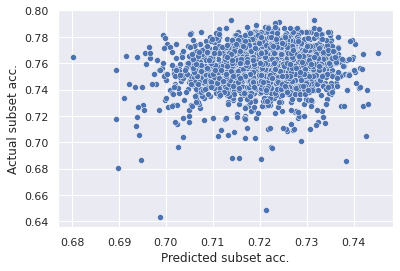

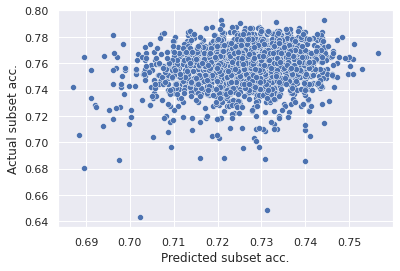

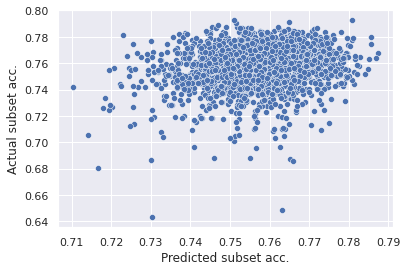

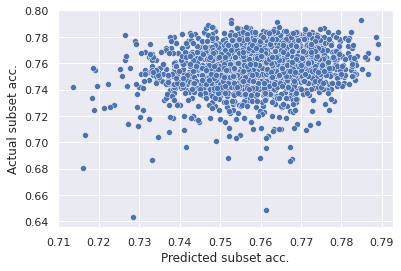

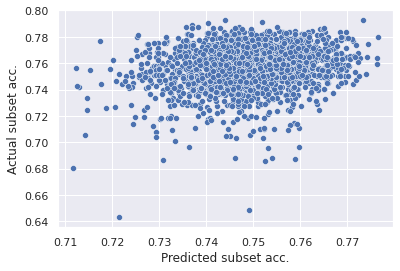

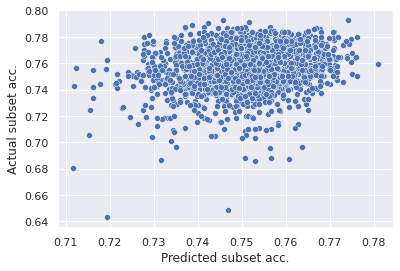

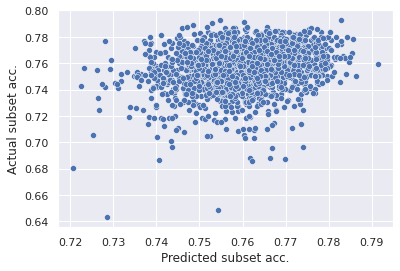

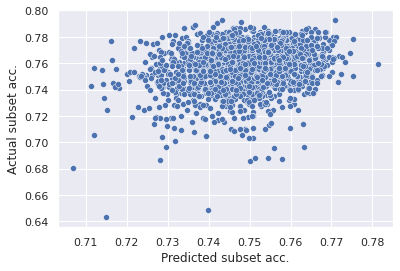

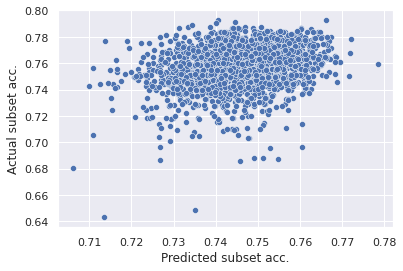

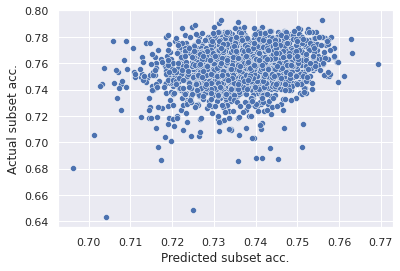

In [13]:
model = DeepSet(embedding, embedding_dim, enc_dim, dec_dim)
model.to(device)

# train_size = 1000
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])
train_dataset = dataset[:2000]
val_dataset = dataset[2000:]

train(model, train_dataset, val_dataset, tolerance=10)

In [14]:
torch.save(model, save_path)